# **Project Description**

**Pre-requisites**
- Create a new GitHub repository for this project. Please make sure that the repository is private and add me (@numadhamani) as a contributor. Once you finish the project, you can remove me as a contributor and make the repository public if you would like. If this is your first time using GitHub, here are some helpful docs: https://guides.github.com/
- Download the Dataset here: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

**Tasks**
- Load the dataset and perform basic exploratory data analysis. 
- Visualize some of the data. Feel free to draw focus to a few key variables and surface any interesting facts or insights you find through visualization. 
- Use the dataset to build a model that will accurately classify which texts are spam.

**Deliverables**
- Code committed to a well-documented GitHub repository that you used to do this analysis. This can be in the form of a script with comments or a Jupyter Notebook. 
- A blog post detailing your analysis, with data visualizations where appropriate. Include details on your thought process and any assumptions or choices you made in the analysis. 


# **Imports**

In [1]:
#basic linear algebra and data wrangling libraries
import numpy as np
import pandas as pd

#vizualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

#nlp toolkits
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud, STOPWORDS

#model selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

#classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

#classification reports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#settings
import time
%matplotlib inline
style.use('seaborn-poster')
style.use('ggplot')

# **Loading Data**

In [2]:
#fetching data from the provided url
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2020-12-02 17:34:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.2’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.1s    

2020-12-02 17:34:41 (1.73 MB/s) - ‘smsspamcollection.zip.2’ saved [203415/203415]



In [3]:
#unziping the file
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
#checking if there is a header
!head SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

In [5]:
#reading the data with pandas
sms = pd.read_table('SMSSpamCollection', header=None)

In [6]:
#renaming the columns
sms.columns = ['label', 'text']
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# **Basic EDA**

- The dataset contains a total of 5572 text messages, where 4825 messages are labeled as ham messages, and 747 messages are labeled as spam.
- The longest message has 910 characters, and is marked as ham.
- The length distribution of messages shows that spam messages tend to contain more characters.

In [7]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
sms.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
sms.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [10]:
#creating a new column that contains the length of the text message
sms['length'] = sms['text'].apply(len)

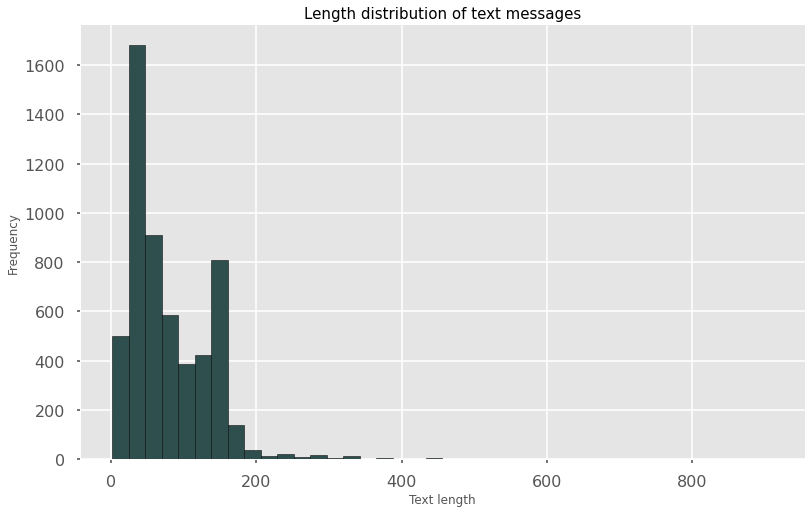

In [11]:
#visualizing the length of text messages
plt.figure(figsize=(13,8))
sms['length'].plot.hist(bins = 40, color = 'darkslategray', ec = 'black')
# plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Text length', fontsize = 12)
plt.title('Length distribution of text messages', fontsize = 15)
plt.show();

In [12]:
#checking for really long messages
sms[sms['length'] > 600]

,label,text,length
1085,ham,For me the love should start with attraction.i...,910
1579,ham,How to Make a girl Happy? It's not at all diff...,611
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629


In [13]:
#displaying the longest sms
sms[sms['length'] > 600]['text'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

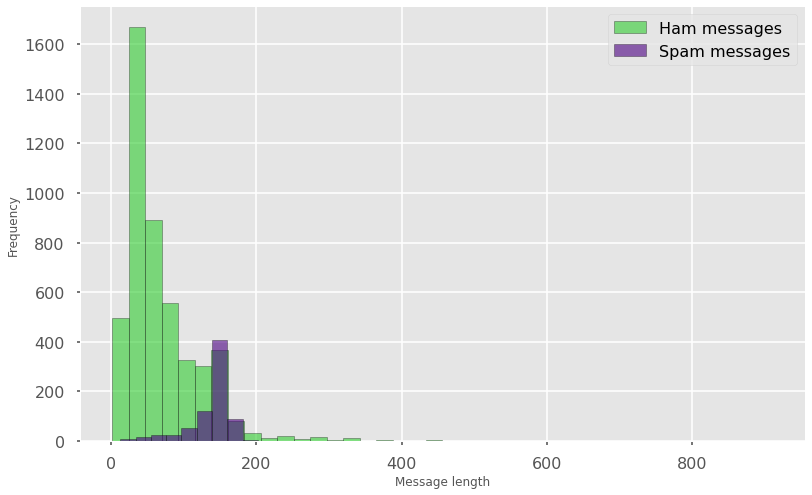

In [14]:
#visualizing length distribution for both ham and spam
plt.figure(figsize=(13,8))
sms[sms.label=='ham'].length.plot.hist(bins = 40, color='limegreen', label='Ham messages', alpha=0.6, ec='black')
sms[sms.label=='spam'].length.plot.hist(bins = 10, color='indigo', label='Spam messages', alpha=0.6, ec='black')
plt.legend()
plt.xlabel("Message length");

In [15]:
#creating a numerical column of the labels
sms['num_label'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,text,length,num_label
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


# **Text Preprocessing**

**Tokenization and removal of punctuation**

In [16]:
#instantiating regex tokenizer that removes punctuation
tokenizer = RegexpTokenizer(r'\w+')

#applying the tokenizer to our text, and lowering all cases
sms['text'] = sms['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

#displaying the first ten messages
sms['text'].head(10)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
5    [freemsg, hey, there, darling, it, s, been, 3,...
6    [even, my, brother, is, not, like, to, speak, ...
7    [as, per, your, request, melle, melle, oru, mi...
8    [winner, as, a, valued, network, customer, you...
9    [had, your, mobile, 11, months, or, more, u, r...
Name: text, dtype: object

**Remove stopwords**

In [17]:
#downloading stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
#creating a function that removes all stopwords from our input
def remove_stopwords(text):
  """
  This function removes stopwords from the provided input
  """
  no_stopwords = [s for s in text if s not in set(stopwords.words('english'))]
  return no_stopwords

In [19]:
#applying the function for removal of stopwords to our text
sms['text'] = sms['text'].apply(lambda x: remove_stopwords(x))

#displaying the first ten messages
sms['text'].head(10)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
5    [freemsg, hey, darling, 3, week, word, back, l...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, 11, months, u, r, entitled, update, l...
Name: text, dtype: object

In [20]:
sms.head()

,label,text,length,num_label
0,ham,"[go, jurong, point, crazy, available, bugis, n...",111,0
1,ham,"[ok, lar, joking, wif, u, oni]",29,0
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",155,1
3,ham,"[u, dun, say, early, hor, u, c, already, say]",49,0
4,ham,"[nah, think, goes, usf, lives, around, though]",61,0


**Removing numbers**

In [21]:
def remove_numbers(text):
  """
  This function removes numbers from the provided input
  """
  no_num = [word for word in text if word.isalpha()]
  return no_num

In [22]:
#applying the function for removal of stopwords to our text
sms['text'] = sms['text'].apply(lambda x: remove_numbers(x))

#displaying the first ten messages
sms['text'].head(10)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
5    [freemsg, hey, darling, week, word, back, like...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, months, u, r, entitled, update, lates...
Name: text, dtype: object

**Wordcloud**

In [23]:
#creating a word cloud function for plotting
def plot_wordcloud(wordcloud):
    """
    This function sets the plotting parameters for the given wordcloud.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.title('Most common words:')
    plt.axis('off');

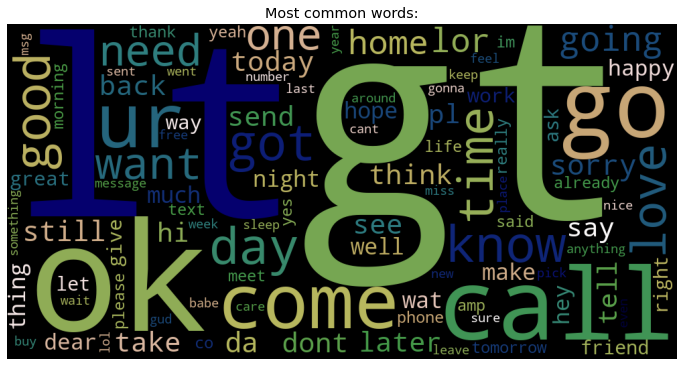

In [24]:
#filtering ham text messages
ham = sms[sms['num_label'] == 0]['text'].apply(lambda x : ' '.join(x))

#creating a word cloud for ham text messages
wordcloud_ham = WordCloud(width = 1000, height = 500, 
                      random_state = 42, background_color = 'black', 
                      colormap = 'gist_earth', collocations = False, 
                      max_words = 100, stopwords = STOPWORDS).generate(' '.join(ham))
plot_wordcloud(wordcloud_ham)

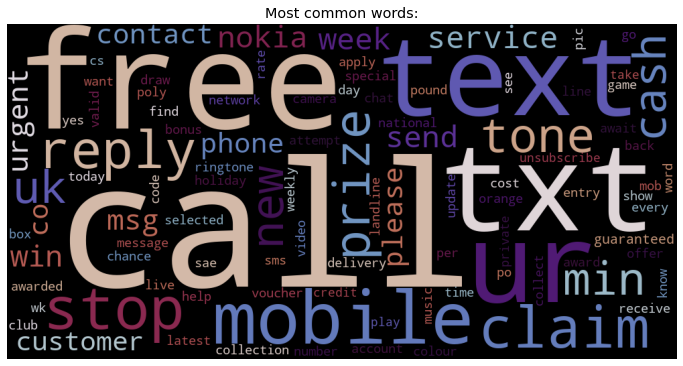

In [25]:
#filtering spam text messages
spam = sms[sms['num_label'] == 1]['text'].apply(lambda x : ' '.join(x))

#creating a word cloud for spam text messages
wordcloud_spam = WordCloud(width = 1000, height = 500, 
                      random_state = 42, background_color = 'black', 
                      colormap = 'twilight_r', collocations = False, 
                      max_words = 100, stopwords = STOPWORDS).generate(' '.join(spam))
plot_wordcloud(wordcloud_spam)

# **Vectorization**

In [26]:
#creating X and y
X = sms['text'].apply(lambda x : ' '.join(x))
y = sms['num_label']

print('Shape of X and y:', X.shape)

Shape of X and y: (5572,)


In [27]:
X

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may...
3                     u dun say early hor u c already say
4                  nah think goes usf lives around though
                              ...                        
5567    time tried contact u u pound prize claim easy ...
5568                          ü b going esplanade fr home
5569                                pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: text, Length: 5572, dtype: object

In [28]:
#instantiating the vectorizer
vectorizer = CountVectorizer()

#converting the text to a matrix of token counts
X_vect = vectorizer.fit_transform(X)

#examining X_vect
X_vect

<5572x7452 sparse matrix of type '<class 'numpy.int64'>'
	with 44312 stored elements in Compressed Sparse Row format>

In [29]:
#instantiating the tfidf transformer
tfidf = TfidfTransformer()

#transforming the corpus to Tfidf corpus
X_transformed = tfidf.fit_transform(X_vect)

#examining X_transformed
X_transformed

<5572x7452 sparse matrix of type '<class 'numpy.float64'>'
	with 44312 stored elements in Compressed Sparse Row format>

# **Training a Model**

**Train Test Split**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.2, random_state = 42)

**Multinomial Naive Bayes Classifier**

In [31]:
%%time

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

CPU times: user 5.01 ms, sys: 0 ns, total: 5.01 ms
Wall time: 7.48 ms


In [32]:
#predictions
pred_mnb = mnb.predict(X_test)

#evaluation
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,pred_mnb))
print("Score:",round(accuracy_score(y_test,pred_mnb) * 100, 2))
print("Classification Report:")
print(classification_report(y_test,pred_mnb))

Confusion Matrix for Multinomial Naive Bayes:
[[966   0]
 [ 27 122]]
Score: 97.58
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.82      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



In [33]:
#cross validation
%%time

y_pred_cv_mnb = cross_val_predict(mnb, X_test, y_test, cv = 10)

#evaluation
print("Cross Validated Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,y_pred_cv_mnb))
print("Score:",round(accuracy_score(y_test,y_pred_cv_mnb) * 100, 2))
print("Classification Report:")
print(classification_report(y_test,y_pred_cv_mnb))

Cross Validated Confusion Matrix for Multinomial Naive Bayes:
[[966   0]
 [100  49]]
Score: 91.03
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       1.00      0.33      0.49       149

    accuracy                           0.91      1115
   macro avg       0.95      0.66      0.72      1115
weighted avg       0.92      0.91      0.89      1115

CPU times: user 34.9 ms, sys: 201 µs, total: 35.1 ms
Wall time: 36.1 ms


**Multilayer Perceptron Classifier**

In [34]:
%%time

mlp = MLPClassifier()
mlp.fit(X_train, y_train)

CPU times: user 29.1 s, sys: 20.4 s, total: 49.5 s
Wall time: 25.2 s


In [35]:
#prediction
pred_mlp = mlp.predict(X_test)

#evaluation
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,pred_mlp))
print("Score:",round(accuracy_score(y_test,pred_mlp) * 100, 2))
print("Classification Report:")
print(classification_report(y_test,pred_mlp))


Confusion Matrix for Multilayer Perceptron Classifier:
[[963   3]
 [ 11 138]]
Score: 98.74
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [36]:
#cross validation
%%time

y_pred_cv_mlp = cross_val_predict(mlp, X_test, y_test, cv = 10)

#evaluation
print("Cross Validated Confusion Matrix for Multilayer Perceptron:")
print(confusion_matrix(y_test,y_pred_cv_mlp))
print("Score:",round(accuracy_score(y_test,y_pred_cv_mlp) * 100, 2))
print("Classification Report:")
print(classification_report(y_test,y_pred_cv_mlp))

Cross Validated Confusion Matrix for Multilayer Perceptron:
[[963   3]
 [ 28 121]]
Score: 97.22
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

CPU times: user 2min 29s, sys: 1min 45s, total: 4min 14s
Wall time: 2min 9s
